In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime,timedelta 
import json
import pickle
# import os
import time

# !pip install matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')


# ETL

## Data extraction (loading from a file)

In [23]:
df = pd.read_csv("/content/data_for_test.csv", dtype={'steps':np.int16, 'time_offset':np.int16})
dateformat = '%Y-%m-%d %H:%M:%S'

## Transformations

### Nones

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9827 entries, 0 to 9826
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time_start_local  9827 non-null   object
 1   time_end_local    9827 non-null   object
 2   time_offset       9827 non-null   int16 
 3   steps             9827 non-null   int16 
dtypes: int16(2), object(2)
memory usage: 192.1+ KB


9827 rows.No nulls. So good so far..

### Anomalies

In [25]:
# df.tail()

In [26]:
df[df.time_start_local > df.time_end_local]

,time_start_local,time_end_local,time_offset,steps
3,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
4,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
8,2022-03-19 08:26:05,2022-03-19 08:25:34,3600,13
12,2022-03-19 12:18:52,2022-03-19 12:18:34,3600,38
15,2022-03-19 12:28:14,2022-03-19 12:18:55,3600,19
...,...,...,...,...
9786,2022-03-29 23:13:13,2022-03-29 23:12:13,3600,113
9794,2022-03-29 23:14:12,2022-03-29 23:13:13,3600,110
9800,2022-03-29 17:54:32,2022-03-29 17:45:15,3600,265
9814,2022-03-29 06:50:38,2022-03-29 06:49:57,3600,37


In [27]:
# time_start_local > df.time_end_local    !!! 
# some rows have time columns reversed
# we have two options:
# - investigate a problem : is it a mistake. Change the order of fields
# - OR drop these rows

In [28]:
# drop time reversed rows:
# df.drop( df[df.time_start_local > df.time_end_local].index , inplace=True)
# df.reset_index(drop=True, inplace=True)

Lets try to change values in affected rows

Focus on row[ 3 ] 

In [29]:
df.loc[3]

time_start_local    2022-03-19 04:52:55
time_end_local      2022-03-19 04:52:50
time_offset                        3600
steps                                 6
Name: 3, dtype: object

In [30]:
# change values between columns   'time_start_local' <--> 'time_end_local'
df[['time_start_local','time_end_local']] = \
    df[['time_end_local','time_start_local']]\
    .where(df['time_start_local'] > df['time_end_local'], \
           df[['time_start_local','time_end_local']].values  )

In [31]:
df.loc[2]

time_start_local    2022-03-19 04:52:50
time_end_local      2022-03-19 04:52:55
time_offset                        3600
steps                                 6
Name: 2, dtype: object

it's OK now

Simple graph

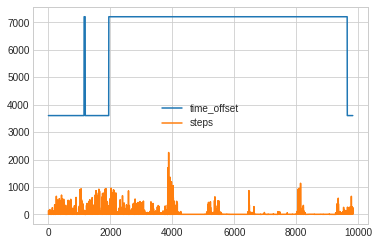

In [32]:
df.plot()

In [33]:
df.loc[df['time_offset'] > 3600]

,time_start_local,time_end_local,time_offset,steps
1150,2022-03-27 08:06:15,2022-03-27 08:06:36,7200,32
1151,2022-03-27 08:08:03,2022-03-27 08:08:16,7200,10
1152,2022-03-27 08:08:03,2022-03-27 08:08:16,7200,10
1153,2022-03-27 08:36:06,2022-03-27 08:36:08,7200,3
1154,2022-03-27 09:03:30,2022-03-27 09:03:32,7200,3
...,...,...,...,...
9641,2022-04-19 22:30:49,2022-04-19 22:30:51,7200,8
9642,2022-04-19 22:35:36,2022-04-19 22:36:27,7200,26
9643,2022-04-19 22:37:42,2022-04-19 22:37:45,7200,10
9644,2022-04-19 22:43:59,2022-04-19 22:44:02,7200,16


In [34]:
df.iloc[1149:1151]

,time_start_local,time_end_local,time_offset,steps
1149,2022-03-26 22:36:38,2022-03-26 22:37:09,3600,19
1150,2022-03-27 08:06:15,2022-03-27 08:06:36,7200,32


Changes in timeoffset values needs to be additionally reviewed...
So far no concerns about that.

### Duplicates

In [35]:
mask = df.duplicated(keep=False) 
print(f"Duplicates : {mask.sum()}")

Duplicates : 4742


Lets take a closer look

In [36]:
df[mask].sort_values(by='time_start_local')

,time_start_local,time_end_local,time_offset,steps
0,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
1,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
2,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
3,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
4,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
...,...,...,...,...
9637,2022-04-19 22:18:22,2022-04-19 22:18:29,7200,15
9640,2022-04-19 22:30:49,2022-04-19 22:30:51,7200,8
9641,2022-04-19 22:30:49,2022-04-19 22:30:51,7200,8
9644,2022-04-19 22:43:59,2022-04-19 22:44:02,7200,16


Obiously it is a duplicated data. Let's drop it down

In [37]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [38]:
df.shape

(7327, 4)

In [39]:
# cast strings to datetime
df['time_start_local']= pd.to_datetime(df['time_start_local'])
df['time_end_local']= pd.to_datetime(df['time_end_local'])

Data is ready for arrangement

## Load

In [47]:
def benchmark( func  ): 
    import time
    
    def wrapper(*args, **kwargs):    
        start = time.time()
        return_value =  func(*args, **kwargs) #, **kwargs
        end = time.time()
        print(f'[*] Execution time: {round(end-start,1)} s')
        return return_value 
    return wrapper


@benchmark
def find_walkings(df, pace_min = 0.5, pace_max = 2, min_session = 300, max_pause = 15):
    '''
    Return a dictionary with a structure as follows:
        
    {
        "<day yyyy-mm-dd>": [  # list of walkings had taken that day
            {
                "start": "<yyyy-mm-dd HH:MM:SS>”,
                "end": "<yyyy-mm-dd HH:MM:SS>",
                "steps": <int>
            },
            …
        ]
    }

        Parameters
        ----------
        pace_min : Minimum pace rate during walking (steps per second).
        pace_max : Maximum pace rate during walking (steps per second).
        min_session: Minimum time to consider the session as a single 
                    walking activity (in seconds).
        max_pause: Maximum pause between records to merge into
                   a single walking activity (in seconds).

        Returns
        -------
        Dictionary.

        Output dictionary is written as a byte stream using python "pickle" library 
        to "walkings.json" file to default local folder.


    '''
    walkings = {}
    day_list = []
    pause = 0
    next_r = 0

    for r in range(len(df)):

        # skip rows we have already read (if next_r > r)
        if next_r == r:

            # merge intervals with acceptable gaps ( < max_pause )

            # current row duration (interval)
            t_int = (df['time_end_local'].loc[r] - df['time_start_local'].loc[r])\
                    .total_seconds()
            steps = df['steps'].loc[r]

            # lookup for next row
            next_r = r + 1
            while next_r < len(df):
                
                # pause between rows (intervals)
                pause = (df['time_start_local'].loc[next_r] - \
                            df['time_end_local'].loc[next_r-1]).total_seconds()
                
                # if next interval starts before previous ends
                if pause < 0:
                    break

                # if pause is acceptable
                if  pause  < max_pause:
                    #  print(f'row:{r}  next_r:{next_r} pause:{pause}  t_int:{t_int}   steps:{steps}')

                    # new interval value 
                    t_int = (df['time_end_local'].loc[next_r] - df['time_start_local']\
                             .loc[r]).total_seconds()  
                    steps += df['steps'].loc[next_r]
                else:
                    
                    break
                
                next_r += 1


            # we have a merged data now
            

            if t_int >= min_session and  pace_min < steps/t_int < pace_max:

                                  
                current_day = df['time_start_local'].loc[r].strftime("%Y-%m-%d")

                # test for a DAY key
                if current_day not in walkings:

                    day_list = []
                    walkings.setdefault(current_day)
                    walkings[current_day] = day_list

                start = df['time_start_local'].loc[r].strftime(dateformat)

                # !!! next_r-1 index
                end = df['time_end_local'].loc[next_r-1].strftime(dateformat)

                walkings[current_day].append(
                                        {'start':start,
                                        'end':end,
                                        'steps':steps,
                                        # 'pace': round(steps / t_int, 1)
                                        }
                                        )
    # write as bytes stream
    with open('walkings.json', 'wb') as f:
        pickle.dump(walkings, f)
    f.close()  

    return walkings

# THE dictionary

In [48]:
walkings = find_walkings(df, pace_min = 0.5, pace_max = 2, min_session = 300, max_pause = 15)

[*] Execution time: 1.3 s


In [49]:
len(walkings)

26

In [43]:
# write as bytes stream
with open('walkings.json', 'wb') as f:
    pickle.dump(walkings, f)
f.close()  

# Evaluation

In [44]:
# test a data format
with open('walkings.json', 'rb') as f:
    dict_ = pickle.load(f)
    f.close()
type(dict_)

dict

In [45]:
len(dict_)

26

In [46]:
dict_['2022-03-29']

[{'start': '2022-03-29 14:22:48', 'end': '2022-03-29 14:31:07', 'steps': 260},
 {'start': '2022-03-29 23:20:23', 'end': '2022-03-29 23:30:08', 'steps': 345},
 {'start': '2022-03-29 19:17:07', 'end': '2022-03-29 19:27:08', 'steps': 660}]